# Part I: Testing out the unit conversion in the bloqade effect

In this part I used Qadence as well to write the adimensional Hamiltonian directly and make sure the unit conversions were working properly. If you are trying to run it using just QoolQit those cells will not work.

For a concrete example of the adimensional units in action, go directly to Part II.

## Blockade effect in the adimensional model

In [1]:
from __future__ import annotations

from qadence import PI, FeatureParameter, HamEvo, N, X

omega = FeatureParameter("omega")
t = FeatureParameter("t")
r = FeatureParameter("r")
    
hamiltonian = (omega/2)*(X(0) + X(1)) + (1/r**6)*(N(0)@N(1))

#################
omega_input = 1.0
r_close = 1.0
r_far = 1.5
t_final = PI
#################

evo = HamEvo(hamiltonian, t)

In [2]:
import torch
from qadence import run

t_val = torch.linspace(0, t_final, 100)

values = {"t": t_val, "r": r_close, "omega": omega_input}

state_close = run(evo, values = values)

values = {"t": t_val, "r": r_far, "omega": omega_input}

state_far = run(evo, values = values)

/Users/joaom/Library/Application Support/hatch/env/virtual/qoolqit/3nsDz3Vh/qoolqit/lib/python3.12/site-packages/pyqtorch/embed.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.arraylike_fn(symbol_or_numeric, device=self.device)


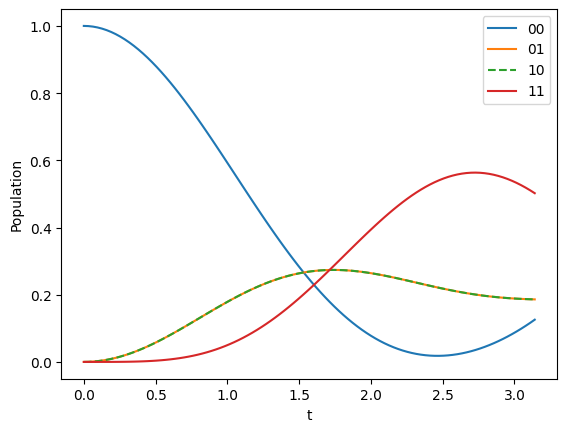

In [3]:
import matplotlib.pyplot as plt

pop = abs(state_close.T)**2

plt.plot(t_val, pop[0], label = "00")
plt.plot(t_val, pop[1], label = "01")
plt.plot(t_val, pop[2], label = "10", linestyle = "dashed")
plt.plot(t_val, pop[3], label = "11")
plt.xlabel("t")
plt.ylabel("Population")
plt.legend()

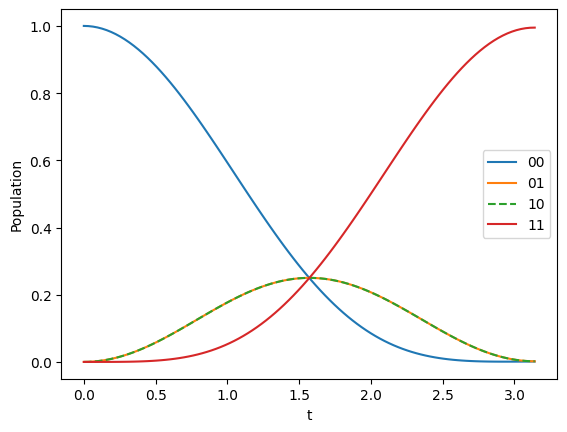

In [4]:
pop = abs(state_far.T)**2

plt.plot(t_val, pop[0], label = "00")
plt.plot(t_val, pop[1], label = "01")
plt.plot(t_val, pop[2], label = "10", linestyle = "dashed")
plt.plot(t_val, pop[3], label = "11")
plt.xlabel("t")
plt.ylabel("Population")
plt.legend()

## Blockade effect in Pulser

In [5]:
import numpy as np
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_simulation import QutipEmulator

#################
omega_input = 1.0
r_close = 1.0
r_far = 1.5
t_final = np.pi
#################

# Depending on a device, unit conversion can be defined
device = MockDevice

c6 = device.interaction_coeff
max_amp = device.channels["rydberg_global"].max_amp or 12

# The unit conversions will depend on an energy renormalization, 
# The obvious choice is the maximum amplitude, but can be chosen arbitrarily
# energy_factor = max_amp
# distance_factor = (c6 / energy_factor) ** (1/6)
# time_factor = 1000 / energy_factor

# New possible conversion based on a reference distance
distance_factor = 8.0
energy_factor = c6 / (distance_factor ** 6)
time_factor = 1000 / energy_factor

n_qubits = 2

spacing_close = r_close * distance_factor

reg_close = Register.rectangle(1, n_qubits, spacing = spacing_close)

spacing_far = r_far * distance_factor

reg_far = Register.rectangle(1, n_qubits, spacing = spacing_far)

In [6]:
def pulser_statevec(result):
    return np.array([np.flip(result[i].state[:].flatten()) for i in range(len(result))])

seq = Sequence(reg_close, device)

seq.declare_channel("rydberg", "rydberg_global")

duration = int(t_final * time_factor)
amplitude = omega_input * energy_factor

generic_pulse = Pulse.ConstantPulse(duration, amplitude, 0.0, 0.0)

seq.add(generic_pulse, "rydberg")

simul = QutipEmulator.from_sequence(seq)

# The Results object in Pulser saves the simulation data over time
res_close = simul.run()

state_close = pulser_statevec(res_close)

In [7]:
seq = Sequence(reg_far, device)

seq.declare_channel("rydberg", "rydberg_global")

duration = int(t_final * time_factor)
amplitude = omega_input * energy_factor

generic_pulse = Pulse.ConstantPulse(duration, amplitude, 0.0, 0.0)

seq.add(generic_pulse, "rydberg")

simul = QutipEmulator.from_sequence(seq)

# The Results object in Pulser saves the simulation data over time
res_far = simul.run()

state_far = pulser_statevec(res_far)

In [8]:
t_range = np.linspace(0, t_final, len(res_far))

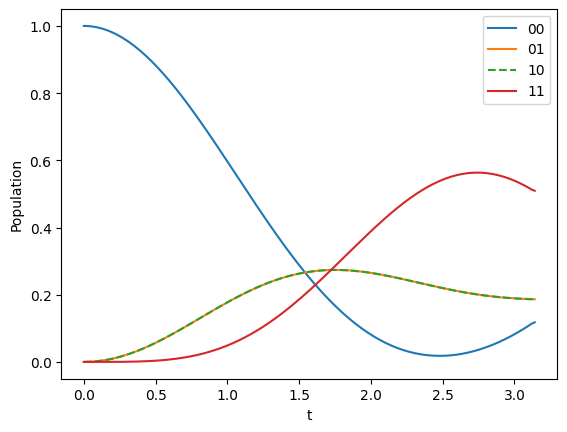

In [9]:
import matplotlib.pyplot as plt

pop = abs(state_close.T)**2

plt.plot(t_range, pop[0], label = "00")
plt.plot(t_range, pop[1], label = "01")
plt.plot(t_range, pop[2], label = "10", linestyle = "dashed")
plt.plot(t_range, pop[3], label = "11")
plt.xlabel("t")
plt.ylabel("Population")
plt.legend()

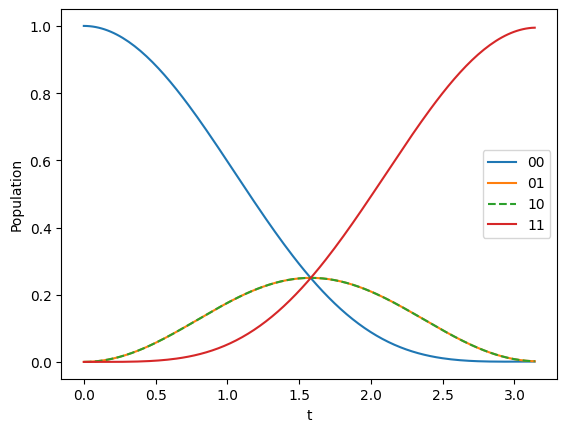

In [10]:
import matplotlib.pyplot as plt

pop = abs(state_far.T)**2

plt.plot(t_range, pop[0], label = "00")
plt.plot(t_range, pop[1], label = "01")
plt.plot(t_range, pop[2], label = "10", linestyle = "dashed")
plt.plot(t_range, pop[3], label = "11")
plt.xlabel("t")
plt.ylabel("Population")
plt.legend()

# Part II: Solving a QUBO

This replicates part of the QUBO example in the Pulser documentation using the adimensional model to emphasize how it separates the algo research from the hardware implementation.

To summarize, the adimensional model essentially means working with the Hamiltonian:

$$
\hat{H}(t)=\sum_{i=0}^{N-1}\frac{\Omega(t)}{2}\left(\cos\phi_i(t)\hat{\sigma}^x_i-\sin\phi_i(t)\hat{\sigma}^y_i\right)-\delta(t)\hat{n}_i+\sum_{i=0}^{N-1}\sum_{j=0}^{i-1}\frac{1}{r^6_{ij}}\hat{n}_i\hat{n}_j
$$

## Option a)
We restrict the user to pick:
- $0\leq\Omega(t)\leq1$, where 1 essentially means the device maximum amplitude.
- $-\delta_\text{max}\leq\delta(t)\leq\delta_\text{max}$, or alternatively we can write $\delta_\text{max}\delta(t)$ in the Hamiltonian and then $-1\leq\delta(t)\leq1$. Either way, we can consider $\delta_\text{max}$ a hyperparameter of the model.

Then, to convert the values to Pulser units we need to perform:

$$
\text{energy} \rightarrow \text{energy} \times \Omega_\text{ref}\qquad
\text{time} \rightarrow \text{time} \times 1000 / \Omega_\text{ref}\qquad
\text{distance} \rightarrow \text{distance} \times (C_6 / \Omega_\text{ref})^{1/6}
$$

With $\Omega_\text{ref}$ and $C_6$ given in the typical Pulser units. $\Omega_\text{ref}$ is an arbitrary reference value for the energy scale. The obvious one to pick is the device $\Omega_\text{max}$, because in the model we say the maximum amplitude allowed is 1.0. However, the fact that it can be picked arbitrarily can be useful.

## Option b)

In a case where we want to have energy in terms of $C_6/d^6$ for some distance $d$, we can have the following conversion:

$$
\text{distance} \rightarrow \text{distance} \times d_\text{ref}\qquad
\text{energy} \rightarrow \text{energy} \times C_6 / d_\text{ref}^6\qquad
\text{time} \rightarrow \text{time} \times 1000 / (C_6 / d_\text{ref}^6)\qquad
$$

With $d_\text{ref}$ and $C_6$ given in the typical Pulser units. This conversion is a rearrangement of the previous one, and it is equivalent in terms of allowing the same adimensional sequence to give the same results in different devices. The reference distance $d_\text{ref}$ is an arbitrary reference value for the distance scale. What would be the obvious one to pick?

In this conversion, what guidelines should the user follow in picking their adimensional values for omega and delta? The guideline of $0\leq\Omega(t)\leq1$ no longer applies, so the option is that the user checks the adimensional device constraints and makes sure he sticks to those.

## An example using Option a)

In [11]:
import numpy as np

# Defining a QUBO instance
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

# Renormalizing because QUBO is scale-invariant. Not done in the Pulser tutorial,
# but seems reasonable since we will be using an adimensional model.
Q = Q / np.max(np.abs(Q))

# Classical solution
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
bitstring_lists = [np.array(list(b), dtype=int) for b in bitstrings]
costs = [z.T @ Q @ z for z in bitstring_lists]
sorted_costs = sorted(zip(bitstrings, costs), key=lambda x: x[1])

print(sorted_costs[:3])

[('01011', -1.319786791539465), ('00111', -1.3197867915394648), ('00101', -0.9501950717990255)]


We now perform the embedding that tries to match the off-diagonal terms of the QUBO with the interaction term. In the adimensional model, that is
$$
U_{ij} = 1/r_{ij}^6
$$

In [12]:
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform


def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(1.0 / pdist(new_coords) ** 6)
    return np.linalg.norm(new_Q - Q)

costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)

res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-8,
    options={"maxiter": 200000, "maxfev": None},
)

adimensional_coords = np.reshape(res.x, (len(Q), 2))

The embedding is now device-independent.

Now, let's assume some heuristic tell you there are some good parameters to solve this QUBO in the adimensional model through an adiabatic pulse schedule. I leave the actual pulse creation for later, but this is essentially going to perform a typical annealing schedule of increasing and decreasing the amplitude `0 -> omega -> 0` while going from negative `delta_i` to positive `delta_f` on the detuning.

The values below are kind of adapted directly from the Pulser tutorial, but there are several options that work.

In [13]:
omega = np.median(Q[Q > 0].flatten()) # As in the Pulser tutorial

adimensional_pulse_spec = {
    "omega": omega,
    "delta_i": - 2.0 * omega,
    "delta_f": 2.0 * omega,
    "duration": 50.0,
}

## Actually running on a device

Now that the "researcher" has done their work, the "experimentalist" is going to pick a device for execution. He has Device0 and Device1, which operate on a different rydberg level, and have lasers that allow a different maximum amplitude.

In [14]:
from pulser.channels import Rydberg
from pulser.devices import VirtualDevice

Device0 = VirtualDevice(
    name = "Device0",
    dimensions = 2,
    rydberg_level = 60,
    channel_objects=(
        Rydberg.Global(
            max_abs_detuning=2 * np.pi * 20,
            max_amp=2 * np.pi * 2.5,
            clock_period=4,
            min_duration=16,
            max_duration=2**26,
        ),)
)

Device1 = VirtualDevice(
    name = "Device1",
    dimensions = 2,
    rydberg_level = 70,
    channel_objects=(
        Rydberg.Global(
            max_abs_detuning=2 * np.pi * 20,
            max_amp=2 * np.pi * 2.5,
            clock_period=4,
            min_duration=16,
            max_duration=2**26,
        ),)
)

The experimentalist can convert the results from the algo researcher for each device:

In [15]:
import numpy as np
from pulser.devices import Device


def uc_omega_ref(device: Device, omega_ref: float | None = None):
    """Computes the unitless -> Pulser conversions for a given device."""

    max_amp = device.channels["rydberg_global"].max_amp or 4.0 * np.pi
    
    energy_factor = omega_ref or max_amp 
    
    c6 = device.interaction_coeff
    
    time_factor = 1000 / energy_factor
    distance_factor = (c6 / energy_factor) ** (1/6)

    return energy_factor, distance_factor, time_factor
    
print("Energy, distance, and time conversion factors for Device0:", uc_omega_ref(Device0))
print("Energy, distance, and time conversion factors for Device1:", uc_omega_ref(Device1))

Energy, distance, and time conversion factors for Device0: (15.707963267948966, 6.168930083417485, 63.66197723675813)
Energy, distance, and time conversion factors for Device1: (15.707963267948966, 8.374946061705455, 63.66197723675813)


The experimentalist now uses the coordinates and pulse parameters to build the actual sequence for each device.

In [16]:
from pulser import InterpolatedWaveform, Pulse, Register, Sequence


def build_annealing_schedule(
    coords: np.array,
    pulse_spec: dict, 
    device: Device, 
    conversion_factors: tuple
) -> Sequence:

    energy_factor, distance_factor, time_factor = conversion_factors
    
    # Register creation
    real_coords = [(c[0] * distance_factor, c[1] * distance_factor) for c in coords]
    qubits = {f"q{i}": coord for (i, coord) in enumerate(real_coords)}
    reg = Register(qubits)

    # Pulse creation
    omega = pulse_spec["omega"] * energy_factor
    delta_i = pulse_spec["delta_i"] * energy_factor
    delta_f = pulse_spec["delta_f"] * energy_factor
    T = int(pulse_spec["duration"] * time_factor)

    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, omega, 1e-9]),
        InterpolatedWaveform(T, [delta_i, 0, delta_f]),
        0,
    )

    # Sequence creation
    seq = Sequence(reg, device)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(adiabatic_pulse, "ising")

    return seq

/Users/joaom/Library/Application Support/hatch/env/virtual/qoolqit/3nsDz3Vh/qoolqit/lib/python3.12/site-packages/pulser/sequence/sequence.py:1281: UserWarning: A duration of 3183 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 3184 ns.
  self._add(pulse, channel, protocol)


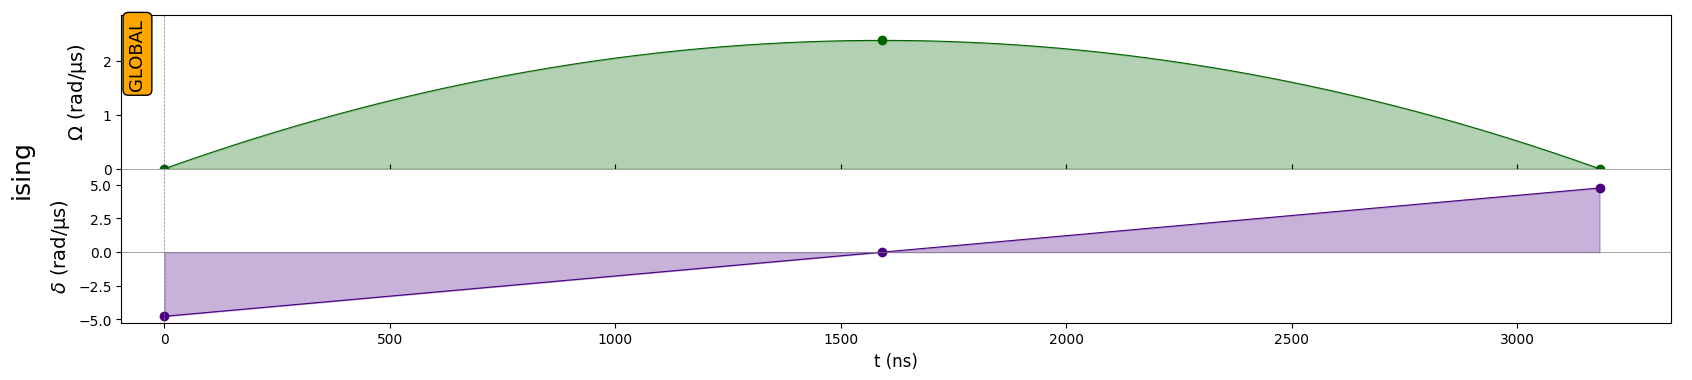

In [17]:
device = Device0

conversion_factors = uc_omega_ref(device)

seq_device0 = build_annealing_schedule(
    adimensional_coords,
    adimensional_pulse_spec,
    device,
    conversion_factors
)

seq_device0.draw()

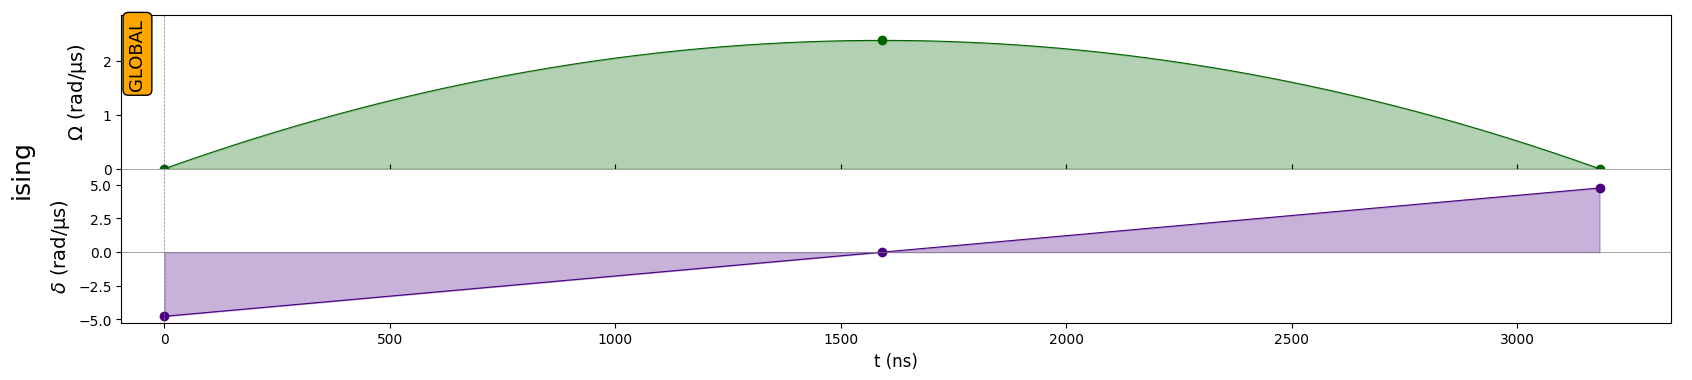

In [18]:
device = Device1

conversion_factors = uc_omega_ref(device)

seq_device1 = build_annealing_schedule(
    adimensional_coords,
    adimensional_pulse_spec,
    device,
    conversion_factors
)

seq_device0.draw()

Now we can run on both devices and check we get the same results (minus sampling variation).

In [19]:
import matplotlib.pyplot as plt


def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

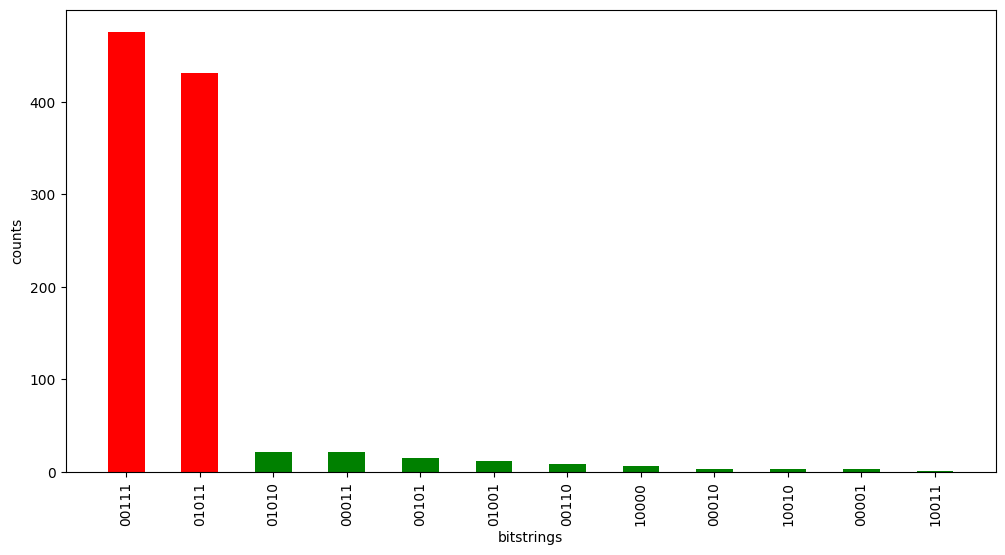

In [20]:
from pulser_simulation import QutipEmulator

# Running on Device0
simul = QutipEmulator.from_sequence(seq_device0)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

plot_distribution(count_dict)

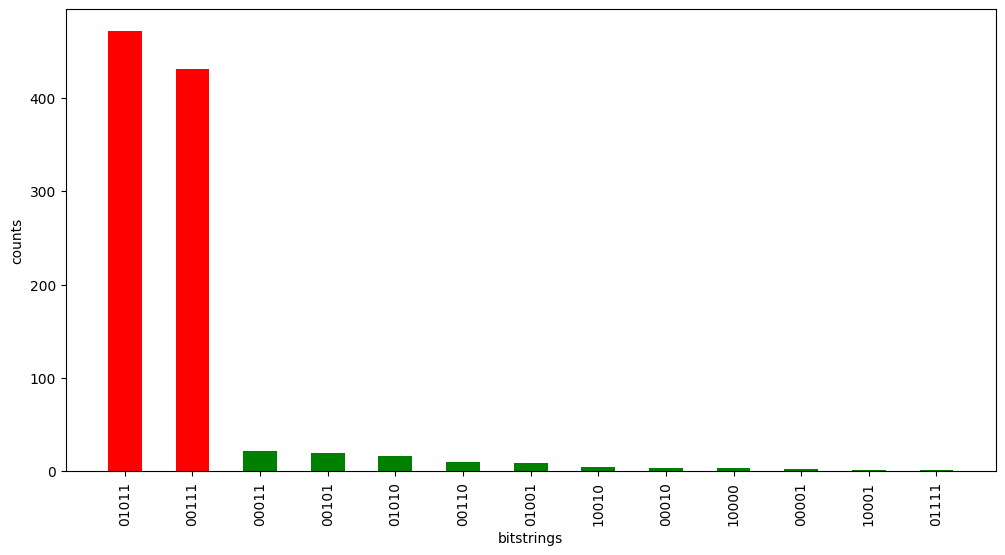

In [21]:
# Running on Device1
simul = QutipEmulator.from_sequence(seq_device1)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

plot_distribution(count_dict)

## Freely adjusting the unit conversion

Note how the "default" conversion was actually not optimal here. The researcher picked a value for omega using some heuristic based on the Q matrix, which ended up being:

In [22]:
adimensional_pulse_spec["omega"]

0.1517731627987461

But he could have gone all the way up to 1.0 to use the laser's maximum amplitude while using a shorter duration pulse. 

Well, we can simply have this done automatically as a compilation to hardware step by automatically defining $\Omega_\text{ref}$ based on whatever is the highest amplitude used in the Sequence to be the device's maximum amplitude. This would "optimize" the sequence to utilize the shortest duration possible. Similar adjustments could be made to optimize the atomic positions or increasing the sequence duration to accomodate some desired hardware constraints with guarantees that it wouldn't change the results the researcher is expecting.

/Users/joaom/Library/Application Support/hatch/env/virtual/qoolqit/3nsDz3Vh/qoolqit/lib/python3.12/site-packages/pulser/sequence/sequence.py:1281: UserWarning: A duration of 487 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 488 ns.
  self._add(pulse, channel, protocol)


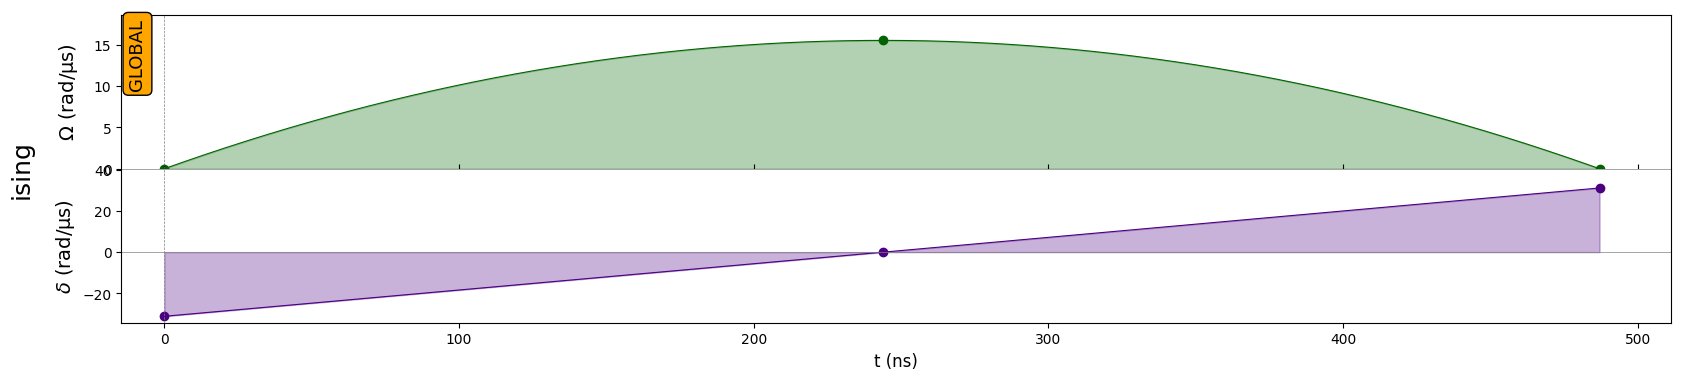

In [23]:
device = Device0

max_amp = device.channels["rydberg_global"].max_amp or 4.0 * np.pi

# This omega_ref essentially maps the maximum amplitude used by the algo
# to be the device maximum amplitude, "compiling" into the shortest possible sequence
omega_ref = max_amp / adimensional_pulse_spec["omega"] * 0.99

conversion_factors = uc_omega_ref(device, omega_ref = omega_ref)

seq_device0_optimal = build_annealing_schedule(
    adimensional_coords,
    adimensional_pulse_spec,
    device,
    conversion_factors
)

seq_device0_optimal.draw()

Note how we now get a ~500 ns sequence instead of ~3000 ns.

And once again we can check we get the same results.

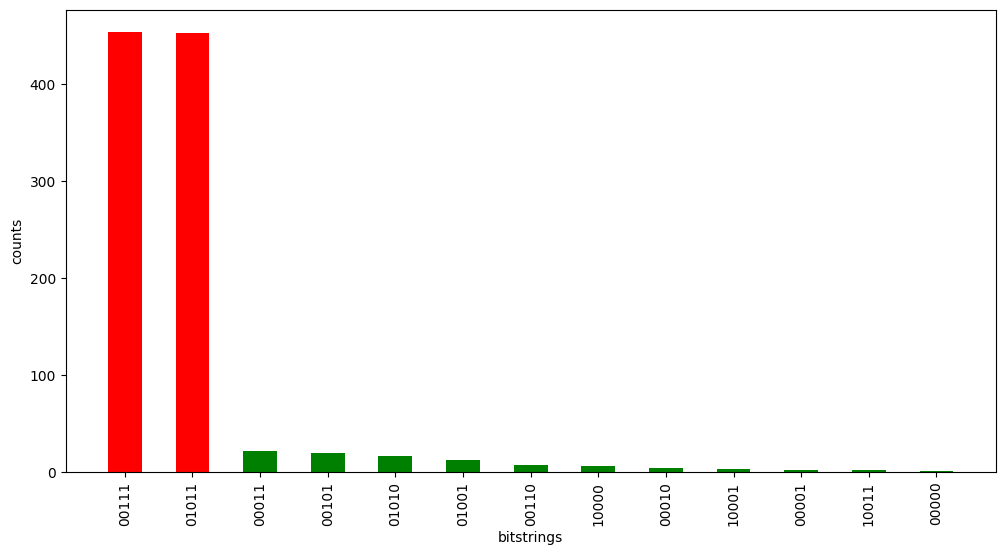

In [24]:
simul = QutipEmulator.from_sequence(seq_device0_optimal)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

plot_distribution(count_dict)

## What if we wanted a different conversion? Directly using Option b)

If instead of fixing a reference omega it is more desireable to fix a reference distance and have the energy unit adapt, we can do so with guarantees we get exactly the same result. First, let's redefine the unit conversion function.

In [25]:
def uc_distance_ref(device: Device, d_ref: float | None = None):
    """Computes the unitless -> Pulser conversions for a given device."""

    distance_factor = d_ref or 7.0
    
    c6 = device.interaction_coeff

    energy_factor = c6 / (distance_factor ** 6)
    time_factor = 1000 / energy_factor

    return energy_factor, distance_factor, time_factor

print("Energy, distance, and time conversion factors for Device0:", uc_distance_ref(Device0))
print("Energy, distance, and time conversion factors for Device1:", uc_distance_ref(Device1))

Energy, distance, and time conversion factors for Device0: (7.3585242543498035, 7.0, 135.89681374072737)
Energy, distance, and time conversion factors for Device1: (46.07058734030889, 7.0, 21.705822689285803)


/Users/joaom/Library/Application Support/hatch/env/virtual/qoolqit/3nsDz3Vh/qoolqit/lib/python3.12/site-packages/pulser/sequence/sequence.py:1281: UserWarning: A duration of 6794 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 6796 ns.
  self._add(pulse, channel, protocol)


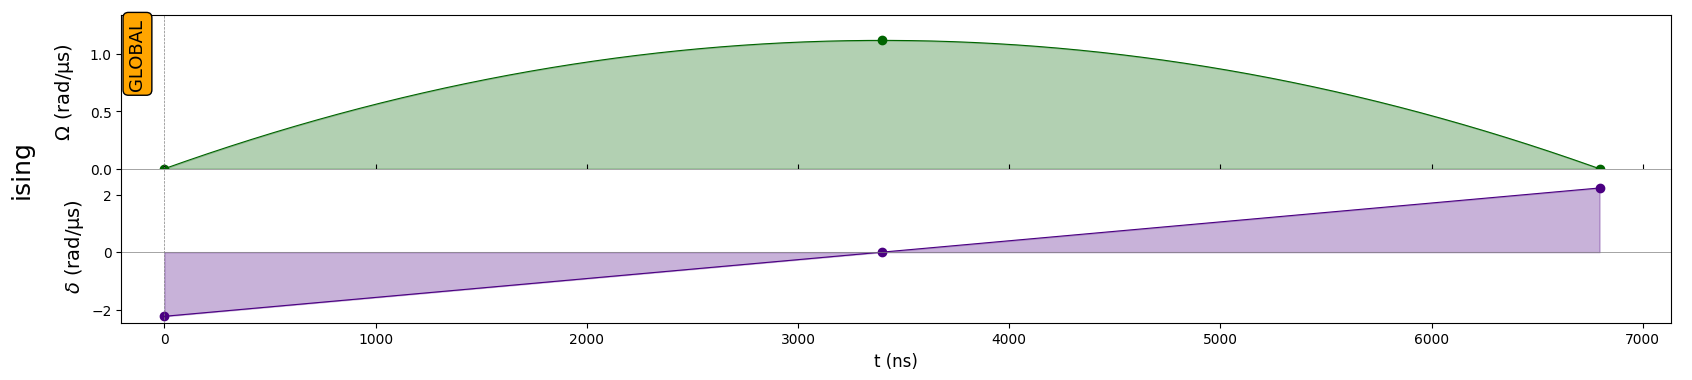

In [26]:
device = Device0

conversion_factors = uc_distance_ref(device)

seq_device0 = build_annealing_schedule(
    adimensional_coords,
    adimensional_pulse_spec,
    device,
    conversion_factors
)

seq_device0.draw()

Again we have guarantees we get exactly the same result.

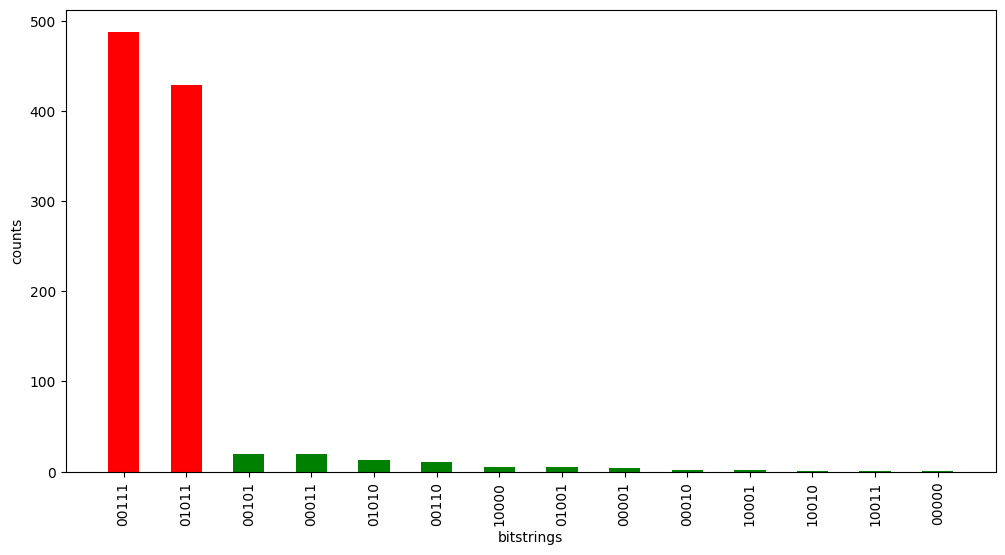

In [27]:
simul = QutipEmulator.from_sequence(seq_device0)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

plot_distribution(count_dict)

We can play with the optimizing the sequence by changing the reference distance. If we again wish to achieve the shortest possible sequence we would need to set reference distance based on the blockade radius when using the maximum amplitude possible.

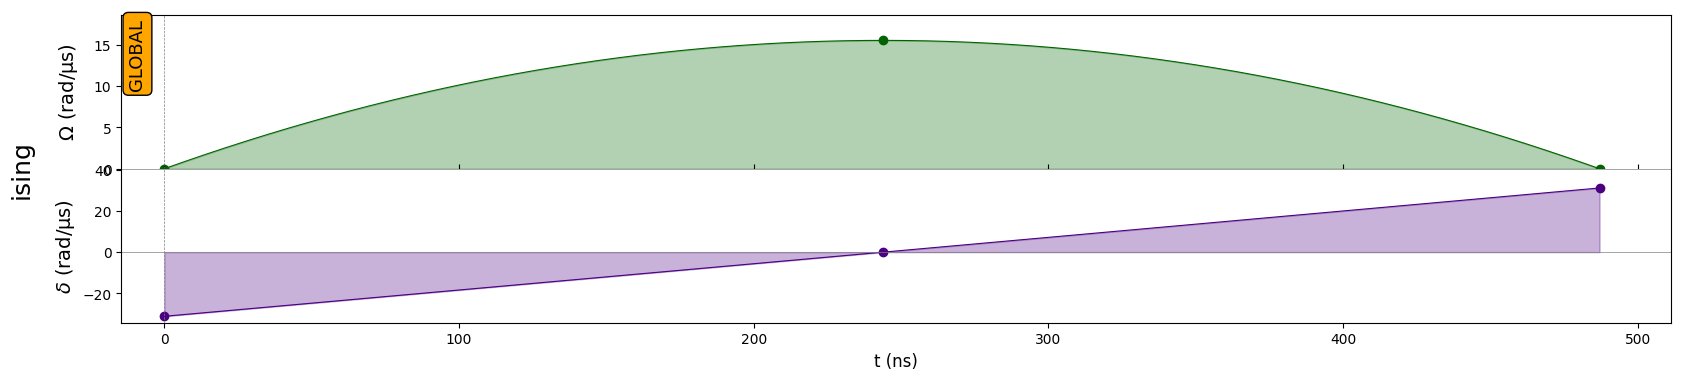

In [28]:
device = Device0

max_amp = device.channels["rydberg_global"].max_amp or 4.0 * np.pi
c6 = device.interaction_coeff
d_ref = (c6 / (0.99 * max_amp / adimensional_pulse_spec["omega"])) ** (1/6)

conversion_factors = uc_distance_ref(device, d_ref = d_ref)

seq_device0_optimal = build_annealing_schedule(
    adimensional_coords,
    adimensional_pulse_spec,
    device,
    conversion_factors
)

seq_device0_optimal.draw()

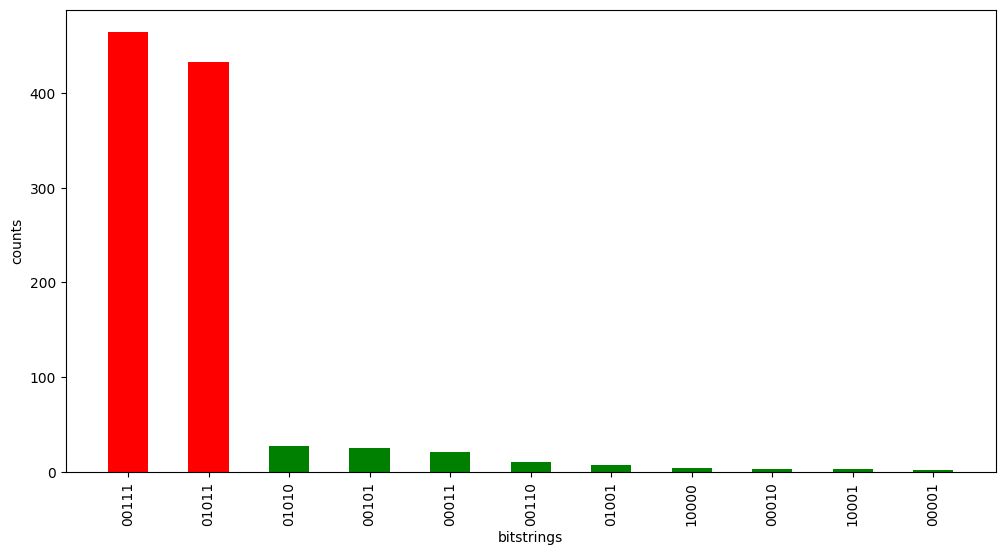

In [29]:
simul = QutipEmulator.from_sequence(seq_device0_optimal)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

plot_distribution(count_dict)